# Imports

In [42]:
# Import pandas
import pandas as pd

# Import matplotlib
import matplotlib.pyplot as plt

# Import numpy
import numpy as np 

# Import Network X
import networkx as nx

# Getting the data

## Paths for in.out files

In [43]:
# Path of IN-labels
mesh_path = '../../data/final/mesh.pkl'

# Path for IN-tags
geo_path = '../../data/final/geo.pkl'

## Read geo_df and mesh_df

In [44]:
# Read
geo_df = pd.read_pickle(geo_path)

# Echo
geo_df.head()

,geo_id,nsamples,date,mesh_id,mesh_heading,category,method
0,200000001,38,2001/01/22,D011379,Prognosis,E,pmid
1,200000001,38,2001/01/22,D016000,Cluster Analysis,E,pmid
2,200000001,38,2001/01/22,D016000,Cluster Analysis,N,pmid
3,200000001,38,2001/01/22,D008297,Male,Sex,pmid
4,200000001,38,2001/01/22,D012333,"RNA, Messenger",D,pmid


In [45]:
# Read
mesh_df = pd.read_pickle(mesh_path)

# Echo
mesh_df.head()

,category,mesh_heading,mesh_id,mesh_treenumbers
0,D,Calcimycin,D000001,D03.633.100.221.173
1,D,Temefos,D000002,D02.705.400.625.800
2,J,Abattoirs,D000003,J01.576.423.200.700.100
3,L,Abbreviations as Topic,D000004,L01.559.598.400.556.131
4,A,Abdomen,D000005,A01.923.047


## Compute category-depth

In [46]:
# Construct grand AstraZeneca dataframe
az_df = pd.merge(geo_df, mesh_df, on='mesh_id')

# Drop extra columns from merge
az_df.drop(columns='mesh_heading_y category_y method'.split(), inplace=True)

# Rename merge column
az_df.rename(columns={'mesh_heading_x':'mesh_heading'}, inplace=True)

# Calculate category - Again
az_df['category']=az_df['mesh_treenumbers'].str.split('.').str[0].str[0]

# Report on propperly classified MeSH-ids category-wise
Propper_Tags = list(az_df['category_x']==az_df['category']).count(True)
Total_Tags = az_df['category_x'].shape[0]
print('Correctly categorized MeSH ids: {:4.1f}%'.format(100*Propper_Tags/Total_Tags))

# Calculate category depth
az_df['depth']=az_df['mesh_treenumbers'].str.split('.').str.len()

# Drop old-category column
az_df.drop(columns='category_x'.split(), inplace=True)

# Echo
az_df.head()

Correctly categorized MeSH ids: 83.6%


,geo_id,nsamples,date,mesh_id,mesh_heading,mesh_treenumbers,category,depth
0,200000001,38,2001/01/22,D011379,Prognosis,E01.789,E,2.0
1,200000088,31,2002/12/08,D011379,Prognosis,E01.789,E,2.0
2,200000089,40,2002/12/08,D011379,Prognosis,E01.789,E,2.0
3,200000349,14,2003/06/26,D011379,Prognosis,E01.789,E,2.0
4,200000350,10,2003/06/26,D011379,Prognosis,E01.789,E,2.0


## Filter and Clean geo DataFrame

In [47]:
# Construct date filter 
mask_date = az_df['date']==az_df['date'] # Take all studies

# Construct category filter
mask_category = ((az_df['category']=='C') | (az_df['category']=='D')) # Drugs and Diseases

# Construct mask to filter high-general categories
mask_depth = True #((az_df['depth']>=2) & (az_df['depth']>=2))

# Construct mask to avoid specific categories
mask_c23 = ~az_df['mesh_treenumbers'].str.startswith('C28', na=False)
mask_avoid_cats = mask_c23

# Apply filters
filtered_geo_df = pd.DataFrame(az_df[mask_date & mask_category & mask_depth & mask_avoid_cats])

# Eliminate filterning columns
filtered_geo_df.drop(columns='date mesh_treenumbers depth'.split(), inplace=True)

# Drop NaNs
filtered_geo_df.dropna(axis=0, inplace=True)

# Drop duplicates
filtered_geo_df.drop_duplicates(inplace=True)

# Only select summaries with +1 tag
tags_by_summary = filtered_geo_df['geo_id mesh_id'.split()].groupby('geo_id').count().reset_index() # Count tags per summary
good_summaries = tags_by_summary[tags_by_summary['mesh_id']>1] # Select abstracts with more than one tag
clean_geo = pd.merge(filtered_geo_df, good_summaries, on='geo_id') # Inner Join
clean_geo = clean_geo.drop(columns='mesh_id_y') # Drop column from inner join
clean_geo = clean_geo.rename(columns={'mesh_id_x':'mesh_id'}) # Rename key column

# Write info
print('Number of Records: ',clean_geo.shape[0])

# Echo
clean_geo.head()

Number of Records:  219953


,geo_id,nsamples,mesh_id,mesh_heading,category
0,200000001,38,D012333,"RNA, Messenger",D
1,200000001,38,D014604,Uveal Neoplasms,C
2,200000001,38,D012878,Skin Neoplasms,C
3,200000001,38,D008545,Melanoma,C
4,200000001,38,D018450,Disease Progression,C


# Constructing the Disease-Drug Graph

## Construct Nodes

In [62]:
# Select only relevant columns
nodes = pd.DataFrame(clean_geo['mesh_id category mesh_heading'.split()])

# Drop duplicates
nodes.drop_duplicates(inplace=True)

# Echo
nodes.head()

,mesh_id,category,mesh_heading
0,D012333,D,"RNA, Messenger"
1,D014604,C,Uveal Neoplasms
2,D012878,C,Skin Neoplasms
3,D008545,C,Melanoma
4,D018450,C,Disease Progression


## Construct Edges

In [63]:
# Construct all-with-all links inside same geoid-nsample-date record
links = pd.merge(clean_geo, clean_geo, on='geo_id nsamples'.split())

# Rename to Source-Target
links.rename(columns={'mesh_id_x':'source', 'mesh_id_y':'target'}, inplace=True)

# Delete self-linkage
links.drop(links[links['source']==links['target']].index, inplace=True)

# Collapse repetitions while calculating weights
edges = links.groupby('source target'.split()).sum().reset_index()

# Rename sum(nsamples) to 'weight'
edges.rename(columns={'nsamples':'weight'}, inplace=True)

# Account for mirror-duplicates
edges['weight']/=2

# Normalize weights
edges['weight']/=edges['weight'].max()

# Head
edges.head()

,source,target,weight
0,D000001,D000230,0.000093
1,D000001,D002110,0.000093
2,D000001,D002118,0.000124
3,D000001,D003029,0.000124
4,D000001,D006474,0.000124


## Construct Graph

In [64]:
# Construct Directed Graph
dd = nx.from_pandas_edgelist(edges, 
                             source='source', 
                             target='target', 
                             edge_attr='weight', 
                             create_using=nx.DiGraph()
                            )

# Transform to undirected graph
dd = nx.to_undirected(dd)

# Add nodes attributes - Category
nx.set_node_attributes(dd, nodes['mesh_id category'.split()].set_index('mesh_id').to_dict()['category'], 'category')

# Add nodes attributes - Mesh Heading
nx.set_node_attributes(dd, nodes['mesh_id mesh_heading'.split()].set_index('mesh_id').to_dict()['mesh_heading'], 'mesh_heading')

# Save as pickle
nx.write_gpickle(dd, 'Disease_Drugs_Graph.pkl')

# Echo info
print('  Size (Nodes): ', dd.size())
print(' Order (Edges): ', dd.order())
print(' Graph Density: ', nx.density(dd))

  Size (Nodes):  439836
 Order (Edges):  6916
 Graph Density:  0.018393890616747108


## Define some useful functions over the tree

In [65]:
def get_categories(graph):
    """
    Get a dictionary with the categories of all the nodes
    """
    return nx.get_node_attributes(graph, 'category')
   
    
def get_mesh_headings(graph):
    """
    Get a dictionary with the mesh-headings of all the nodes
    """
    return nx.get_node_attributes(graph, 'mesh_heading')
    

def get_neighbors(graph, node, cats):
    """
    Get the neighbors of the node such that they have the same/opposite category
    """
        
    # Define empty lists
    same = list()
    oppo = list()
        
    # Select only those with same category
    for neigh in nx.neighbors(dd, node):
            
        # Check for same neighbors
        if cats[neigh]==cats[node]:
            same.append(neigh)
        else:
            oppo.append(neigh)
                
    # Return the tuples same and oppo
    return same, oppo
    
    
def get_top(dictionary_metric, top):
    """
    Find the top-n nodes according to some metric
    """
    
    # Get the items in the metric dictionary
    items = list(dictionary_metric.items())
    
    # Sort them out
    items.sort(reverse=True, key=lambda x: x[1])
    
    # Return the keys
    return list(map(lambda x:x[0], items[:top]))


def get_only(graph, cats, specific_category):
    """
    Select the nodes of the graph where category==category and returns a subgraph
    """
    
    # Define empty list
    only_nodes = list()
    
    # Cycle through the nodes
    for node in graph.nodes():
        if cats[node]==specific_category:
            only_nodes.append(node)
    
    # Return the subgraph
    return nx.subgraph(graph, only_nodes)  

## Export files for Gephi

In [66]:
# Rename node columns
nodes.rename(columns={'mesh_id':'id', 'mesh_heading':'label', 'category':'type'}, inplace=True)

# Type to binary
to_replace={'type':{'C':True, 'D':False}}
nodes.replace(to_replace, inplace=True)

# Reorganize
nodes=nodes['id label type'.split()]

# Export nodes to CSV
nodes.to_csv('gephi_nodes.csv', index=False)

# Export edges to CSV
edges.to_csv('gephi_edges.csv', index=False)

# Recomend drugs for top diseases ['C']

## Select diseases

In [12]:
# Read full graph
ee = nx.read_gpickle('Disease_Drugs_Graph.pkl')

# Read categories and labels
cats = get_categories(graph=ee)
labs = get_mesh_headings(graph=ee)

# Choose only disease-nodes
diseases = get_only(graph=ee, cats=cats, specific_category='C')

## Runs stats on diseases

In [13]:
# Disease eigenvector centrality
diseases_eig = nx.eigenvector_centrality(diseases, max_iter=500, weight='weight')

# Disease PageRank 
diseases_pgn = nx.pagerank(diseases, alpha=0.9, weight='weight')

# Disease Degree 
diseases_deg = nx.degree_centrality(diseases)

## Choose n-top disease nodes

In [14]:
# Find top-diseases
top = 100
top_eig = get_top(dictionary_metric=diseases_eig, top=top)
top_pgn = get_top(dictionary_metric=diseases_pgn, top=top)
top_deg = get_top(dictionary_metric=diseases_deg, top=top)
top_diseases = top_eig

## Measure recommendation-strenght (rs)

In [15]:
# Define containers of important recommendations
rs = list()

# Choose a node
for disease in top_diseases:

    # Get neighbors diseases and neighboring drugs
    nei_dis, nei_dru = get_neighbors(graph=dd, node=disease, cats=cats)

    # Get max possible weight
    ww_max = sum([dd.get_edge_data(disease, nei, 'weight')['weight'] for nei in nei_dis])
    
    # For every neighboring disease
    for n_disease in nei_dis:

        # Find all the neighboring drugs 
        _ , nei_nei_dru = get_neighbors(graph=dd, node=n_disease, cats=cats) 

        # Chose drugs not in nei_dru
        not_in_nei_dru = list(set(nei_nei_dru) - set(nei_dru))

        # Add them to rs with weight
        c1 = [disease]*len(not_in_nei_dru)
        c2 = not_in_nei_dru
        ww = dd.get_edge_data(disease, n_disease, 'weight')['weight']
        c3 = [ww/ww_max]*len(not_in_nei_dru)
        
        rs.extend(zip(c1, c2, c3))

# Get into a DF
rs = pd.DataFrame(data=rs, columns='Disease Drug Recommendation_Strenght'.split())

# Group by disease-drug pairs and add the weights
rs = pd.DataFrame(rs.groupby('Disease Drug'.split()).sum().reset_index())

# Echo
rs.head()

,Disease,Drug,Recommendation_Strenght
0,D000077192,D000001,0.256587
1,D000077192,D000017,0.160544
2,D000077192,D000067596,0.205000
3,D000077192,D000067616,0.002928
4,D000077192,D000067759,0.170011


## Present labeled table of rs'

In [16]:
# Merge on Disease=Mesh_id
rs_named_1 = pd.merge(rs.rename(columns={'Disease':'mesh_id'}), mesh_df, on='mesh_id')

# Remove unwanted columns
rs_named_1.drop(columns='category mesh_treenumbers'.split(), inplace=True)

# Rename mesh_headings
rs_named_1.rename(columns={'mesh_heading':'Disease', 'mesh_id':'Disease_id'}, inplace=True)

# Re-Organize
rs_named_1 = rs_named_1['Disease Disease_id Drug Recommendation_Strenght'.split()]



# Merge on Drug=Mesh_id
rs_named_2 = pd.merge(rs_named_1.rename(columns={'Drug':'mesh_id'}), mesh_df, on='mesh_id')

# Remove unwanted columns
rs_named_2.drop(columns='category mesh_treenumbers'.split(), inplace=True)

# Rename mesh_headings
rs_named_2.rename(columns={'mesh_heading':'Drug', 'mesh_id':'Drug_id'}, inplace=True)

# Re-Organize
rs_named_2 = rs_named_2['Disease Disease_id Drug_id Drug Recommendation_Strenght'.split()]



# Clean duplicates
rs_clean = rs_named_2.drop_duplicates().reset_index(drop=True)

# Sort by r-strenght
rs_clean.sort_values(by='Recommendation_Strenght Disease Drug'.split(), inplace=True, ascending=False)

# Reset index
rs_clean.reset_index(inplace=True, drop=True)

# Echo
print('Size of rs: ', rs_clean.shape)
rs_clean.head(25)

Size of rs:  (323160, 5)


,Disease,Disease_id,Drug_id,Drug,Recommendation_Strenght
0,Oligodendroglioma,D009837,D034741,"RNA, Small Interfering",0.990021
1,Hirschsprung Disease,D006627,D015415,Biomarkers,0.989013
2,Hirschsprung Disease,D006627,D025521,Tumor Suppressor Proteins,0.988025
3,Hirschsprung Disease,D006627,D016207,Cytokines,0.987285
4,Hirschsprung Disease,D006627,D004273,"DNA, Neoplasm",0.985803
5,Hirschsprung Disease,D006627,D015850,Interleukin-6,0.985063
6,Hirschsprung Disease,D006627,D050796,STAT3 Transcription Factor,0.983334
7,"Shock, Hemorrhagic",D012771,D012333,"RNA, Messenger",0.981664
8,"Shock, Hemorrhagic",D012771,D007372,Interferons,0.981664
9,"Shock, Hemorrhagic",D012771,D005819,Genetic Markers,0.981664


## Visualization of rs

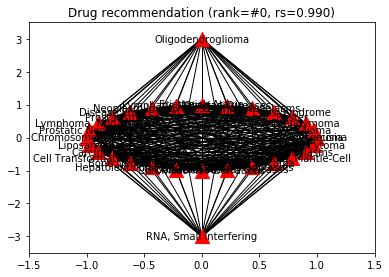

In [27]:
# Choose input
cardinality = 0

# Get nodes
dis_node = rs_clean['Disease_id'].iloc[cardinality]
dru_node = rs_clean['Drug_id'].iloc[cardinality]
dis_neighs, _ = get_neighbors(graph=ee, node=dis_node, cats=cats)

# Gather nodes
my_nodes = [dis_node, dru_node]
my_nodes.extend(dis_neighs)

# Gather categories
my_cats={node:cats[node] for node in my_nodes}

# Gather colors
my_colr=dict()
for node, cat in my_cats.items():
    if cat=='C':
        my_colr[node]='b'
    elif cat=='D':
        my_colr[node]='r'
my_colr[dis_node]='g'
        
# Gather labels
my_labs={node:labs[node] for node in my_nodes}

# Gather positions
eps = 3
angle = np.linspace(0, 2*np.pi, len(my_nodes)-2)
radius = np.ones(len(my_nodes)-2)
x_pos, y_pos = radius*np.cos(angle), radius*np.sin(angle)
my_poss=dict()
my_poss[dis_node]=(0, +eps)
my_poss[dru_node]=(0, -eps)
for i in range(len(my_nodes)-2):
    my_poss[dis_neighs[i]]=(x_pos[i], y_pos[i])

# Construct subgraph
ee_sub = ee.subgraph(my_nodes)

# Plot
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])

nx.draw_networkx_labels(ee_sub, pos=my_poss, labels=my_labs, font_size=10)
nx.draw_networkx(ee_sub, pos=my_poss, node_size=200, node_shape='^', with_labels=False)

titulo='Drug recommendation (rank=#{:}, rs={:3.3f})'.format(
    cardinality,
    rs_clean['Recommendation_Strenght'].iloc[cardinality])
axes.set_title(titulo)
axes.set_xlim(-1.5,1.5)
axes.set_ylim(-3.5,3.5)

plt.axis()
plt.savefig('dru_rec/drug_recommendation_{:07d}.png'.format(cardinality), dpi=500)
plt.show()

# Recomend disease for top drug ['D']

## Select drugs

In [28]:
# Read full graph
ee = nx.read_gpickle('Disease_Drugs_Graph.pkl')

# Read categories and labels
cats = get_categories(graph=ee)
labs = get_mesh_headings(graph=ee)

# Choose only drug-nodes
drugs = get_only(graph=ee, cats=cats, specific_category='D')

## Runs stats on drugs

In [29]:
# Drugs eigenvector centrality
drugs_eig = nx.eigenvector_centrality(drugs, max_iter=500, weight='weight')

# Drugs PageRank 
drugs_pgn = nx.pagerank(drugs, alpha=0.9, weight='weight')

# Drugs Degree 
drugs_deg = nx.degree_centrality(drugs)

## Select n-top drugs

In [30]:
# Find top-diseases
top = 100
top_eig = get_top(dictionary_metric=drugs_eig, top=top)
top_pgn = get_top(dictionary_metric=drugs_pgn, top=top)
top_deg = get_top(dictionary_metric=drugs_deg, top=top)
top_drugs = top_eig

## Compute recommendation-strenght (rs)

In [31]:
# Define containers of important recommendations
rs = list()

# Choose a node
for drug in top_drugs:

    # Get neighbors diseases and neighboring drugs
    nei_dru, nei_dis = get_neighbors(graph=dd, node=drug, cats=cats)

    # Get max possible weight
    ww_max = sum([dd.get_edge_data(drug, nei, 'weight')['weight'] for nei in nei_dru])
    
    # For every neighboring drug
    for n_drug in nei_dru:

        # Find all the neighboring diseases 
        _, nei_nei_dis = get_neighbors(graph=dd, node=n_drug, cats=cats) 

        # Chose disease not in nei_dis
        not_in_nei_dis = list(set(nei_nei_dis) - set(nei_dis))

        # Add them to rs with weight
        c1 = [drug]*len(not_in_nei_dis)
        c2 = not_in_nei_dis
        ww = dd.get_edge_data(drug, n_drug, 'weight')['weight']
        c3 = [ww/ww_max]*len(not_in_nei_dis)
        
        rs.extend(zip(c1, c2, c3))

# Get into a DF
rs = pd.DataFrame(data=rs, columns='Drug Disease Recommendation_Strenght'.split())

# Group by disease-drug pairs and add the weights
rs = pd.DataFrame(rs.groupby('Drug Disease'.split()).sum().reset_index())

# Echo
rs.head()

,Drug,Disease,Recommendation_Strenght
0,D000071221,D000008,0.080545
1,D000071221,D000012,0.170253
2,D000071221,D000013,0.290381
3,D000071221,D000014,0.026598
4,D000071221,D000015,0.278363


## Present  labeled table of rs'

In [32]:
# Merge on Disease=Mesh_id
rs_named_1 = pd.merge(rs.rename(columns={'Drug':'mesh_id'}), mesh_df, on='mesh_id')

# Remove unwanted columns
rs_named_1.drop(columns='category mesh_treenumbers'.split(), inplace=True)

# Rename mesh_headings
rs_named_1.rename(columns={'mesh_heading':'Drug', 'mesh_id':'Drug_id'}, inplace=True)

# Re-Organize
rs_named_1 = rs_named_1['Drug Drug_id Disease Recommendation_Strenght'.split()]



# Merge on Drug=Mesh_id
rs_named_2 = pd.merge(rs_named_1.rename(columns={'Disease':'mesh_id'}), mesh_df, on='mesh_id')

# Remove unwanted columns
rs_named_2.drop(columns='category mesh_treenumbers'.split(), inplace=True)

# Rename mesh_headings
rs_named_2.rename(columns={'mesh_heading':'Disease', 'mesh_id':'Disease_id'}, inplace=True)

# Re-Organize
rs_named_2 = rs_named_2['Drug Drug_id Disease_id Disease Recommendation_Strenght'.split()]



# Clean duplicates
rs_clean = rs_named_2.drop_duplicates().reset_index(drop=True)

# Sort by r-strenght
rs_clean.sort_values(by='Recommendation_Strenght Drug Disease'.split(), inplace=True, ascending=False)

# Reset index
rs_clean.reset_index(inplace=True, drop=True)

# Echo
print('Size of rs: ', rs_clean.shape)
rs_clean.head(25)

Size of rs:  (173093, 5)


,Drug,Drug_id,Disease_id,Disease,Recommendation_Strenght
0,Deoxyribonuclease I,D003850,D015179,Colorectal Neoplasms,0.993392
1,Deoxyribonuclease I,D003850,D002471,"Cell Transformation, Neoplastic",0.992696
2,Deoxyribonuclease I,D003850,D006528,"Carcinoma, Hepatocellular",0.991611
3,Deoxyribonuclease I,D003850,D008113,Liver Neoplasms,0.991530
4,Deoxyribonuclease I,D003850,D016393,"Lymphoma, B-Cell",0.990963
5,Deoxyribonuclease I,D003850,D009361,Neoplasm Invasiveness,0.990704
6,Deoxyribonuclease I,D003850,D005910,Glioma,0.990639
7,Deoxyribonuclease I,D003850,D001932,Brain Neoplasms,0.990639
8,Deoxyribonuclease I,D003850,D004195,"Disease Models, Animal",0.990169
9,Deoxyribonuclease I,D003850,D003110,Colonic Neoplasms,0.990121


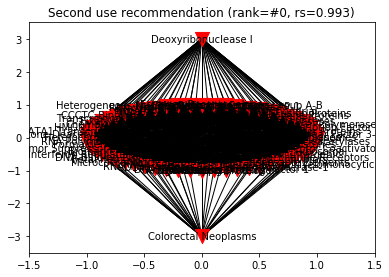

In [41]:
# Choose input
cardinality = 0

# Get nodes
dru_node = rs_clean['Drug_id'].iloc[cardinality]
dis_node = rs_clean['Disease_id'].iloc[cardinality]
dru_neighs, _ = get_neighbors(graph=ee, node=dru_node, cats=cats)

# Gather nodes
my_nodes = [dru_node, dis_node]
my_nodes.extend(dru_neighs)

# Gather categories
my_cats={node:cats[node] for node in my_nodes}

# Gather colors
my_colr=dict()
for node, cat in my_cats.items():
    if cat=='C':
        my_colr[node]='b'
    elif cat=='D':
        my_colr[node]='r'
my_colr[dis_node]='g'
        
# Gather labels
my_labs={node:labs[node] for node in my_nodes}

# Gather positions
eps = 3
angle = np.linspace(0, 2*np.pi, len(my_nodes)-2)
radius = np.ones(len(my_nodes)-2)
x_pos, y_pos = radius*np.cos(angle), radius*np.sin(angle)
my_poss=dict()
my_poss[dru_node]=(0, +eps)
my_poss[dis_node]=(0, -eps)
for i in range(len(my_nodes)-2):
    my_poss[dru_neighs[i]]=(x_pos[i], y_pos[i])

# Construct subgraph
ee_sub = ee.subgraph(my_nodes)

# Plot
fig = plt.figure()
axes = fig.add_axes([0.1,0.1,0.8,0.8])

nx.draw_networkx_labels(ee_sub, pos=my_poss, labels=my_labs, font_size=10)
nx.draw_networkx(ee_sub, pos=my_poss, node_size=200, node_shape='v', with_labels=False)

titulo='Second use recommendation (rank=#{:}, rs={:3.3f})'.format(
    cardinality,
    rs_clean['Recommendation_Strenght'].iloc[cardinality])
axes.set_title(titulo)
axes.set_xlim(-1.5,1.5)
axes.set_ylim(-3.5,3.5)

plt.axis()
plt.savefig('dis_rec/second_use_recommendation_{:07d}.png'.format(cardinality))
plt.show()

# End